# Word Embeddings

In [179]:
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import unicodedata
import string

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/abdala9512/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/abdala9512/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
def process_text(text,  keep_as_list = False):
    '''
    Input:
        text: a string containing a text
    Output:
        text_clean: a list of words containing the processed text

    '''
    stemmer = SnowballStemmer('spanish')
    stopwords_ = stopwords.words('spanish')
    text_tokens = word_tokenize(text)

    text_clean = []
    for word in text_tokens:
        if (word not in stopwords_ and  # remove stopwords
                word not in string.punctuation and 
            word.isalpha()):  # remove punctuation
            #stemmed_word = stemmer.stem(word)
            text_clean.append(word)
    if keep_as_list:
        return text_clean
    return ' '.join(text_clean)


def remove_accent(text: str):
    
    unaccented_text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")
    return unaccented_text

def basic_cleaning(dataframe: pd.DataFrame, text_cols: list = None):
    
    # Strip text
    for col in dataframe.select_dtypes("object").columns:
        dataframe[col] = dataframe[col].str.strip()
        dataframe[col] = dataframe[col].str.lower()
    
    # Remove tildes
    if text_cols:
        for col in dataframe[text_cols].columns:
            dataframe[col] = dataframe[col].apply(lambda x: remove_accent(str(x)))
    return dataframe


In [43]:
data = pd.read_csv("../../data/ArchivoProblemas.csv", sep=";",header=None,error_bad_lines=False)
data.columns = ["target", "id", "text"]
data

/tmp/ipykernel_379/2875557891.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv("../../data/ArchivoProblemas.csv", sep=";",header=None,error_bad_lines=False)


,target,id,text
0,Problem,3655.0,"Deficiencia en las reglas, protocolos y proces..."
1,Effect,18181.0,Descoordinación institucional en el tema de at...
2,Effect,18182.0,Ineficiencia e ineficacia en la atención a víc...
3,Effect,18183.0,Inequidad social
4,Effect,18626.0,Baja capacidad de las entidades territoriales ...
...,...,...,...
13032,Cause,2939.0,Requerimientos legales sin cumplir
13033,Cause,2940.0,El funcionamiento de la Universidad no esta ga...
13034,Cause,2941.0,Poca gestión institucional dentro de los proce...
13035,Cause,2942.0,éficit de recursos económicos y financieros


In [55]:
data = basic_cleaning(data, text_cols=["text"])
data["text_tokenized"] = data["text"].apply(lambda x: process_text(x, keep_as_list=True))
data

,target,id,text,text_tokenized
0,problem,3655.0,"deficiencia en las reglas, protocolos y proces...","[deficiencia, reglas, protocolos, procesos, co..."
1,effect,18181.0,descoordinacion institucional en el tema de at...,"[descoordinacion, institucional, tema, atencio..."
2,effect,18182.0,ineficiencia e ineficacia en la atencion a vic...,"[ineficiencia, ineficacia, atencion, victimas,..."
3,effect,18183.0,inequidad social,"[inequidad, social]"
4,effect,18626.0,baja capacidad de las entidades territoriales ...,"[baja, capacidad, entidades, territoriales, im..."
...,...,...,...,...
13032,cause,2939.0,requerimientos legales sin cumplir,"[requerimientos, legales, cumplir]"
13033,cause,2940.0,el funcionamiento de la universidad no esta ga...,"[funcionamiento, universidad, garantizado]"
13034,cause,2941.0,poca gestion institucional dentro de los proce...,"[poca, gestion, institucional, dentro, proceso..."
13035,cause,2942.0,eficit de recursos economicos y financieros,"[eficit, recursos, economicos, financieros]"


# Embeddings

In [188]:
"""Emedding visualizacion Tool"""

import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from typing import Any

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)

def visualize_embedding(
    key_to_vector_embedding: dict, 
    algorithm: Any, 
    word_limit: int = 20) -> None:
    """Crea una visualizacion de embeddings
    """
    assert (
        isinstance(algorithm, PCA) or 
        isinstance(algorithm, TSNE) or
        isinstance(algorithm, UMAP)
    ), "La visualizacion solo funciona con instancias PCA, TSNE o UMAP"
    
    vectors = []
    labels = []
    for key, vector in key_to_vector_embedding.items():
        vectors.append(vector)
        labels.append(key)
        
    reduced_2d_data = algorithm.fit_transform(np.array(vectors))
    x, y =  reduced_2d_data[:, 0], reduced_2d_data[:, 1]
    
    for i in range(word_limit):
        plt.scatter(x[i],y[i], color="#59C1BD")
        plt.annotate(
            labels[i],
            xy=(x[i], y[i]),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom',
        )
    plt.xlabel("Dim 1", size=15)
    plt.ylabel("Dim 2", size=15)
    plt.title("Representacion Embeddings",size=30)

# Ejemplo Viz. Emebdding

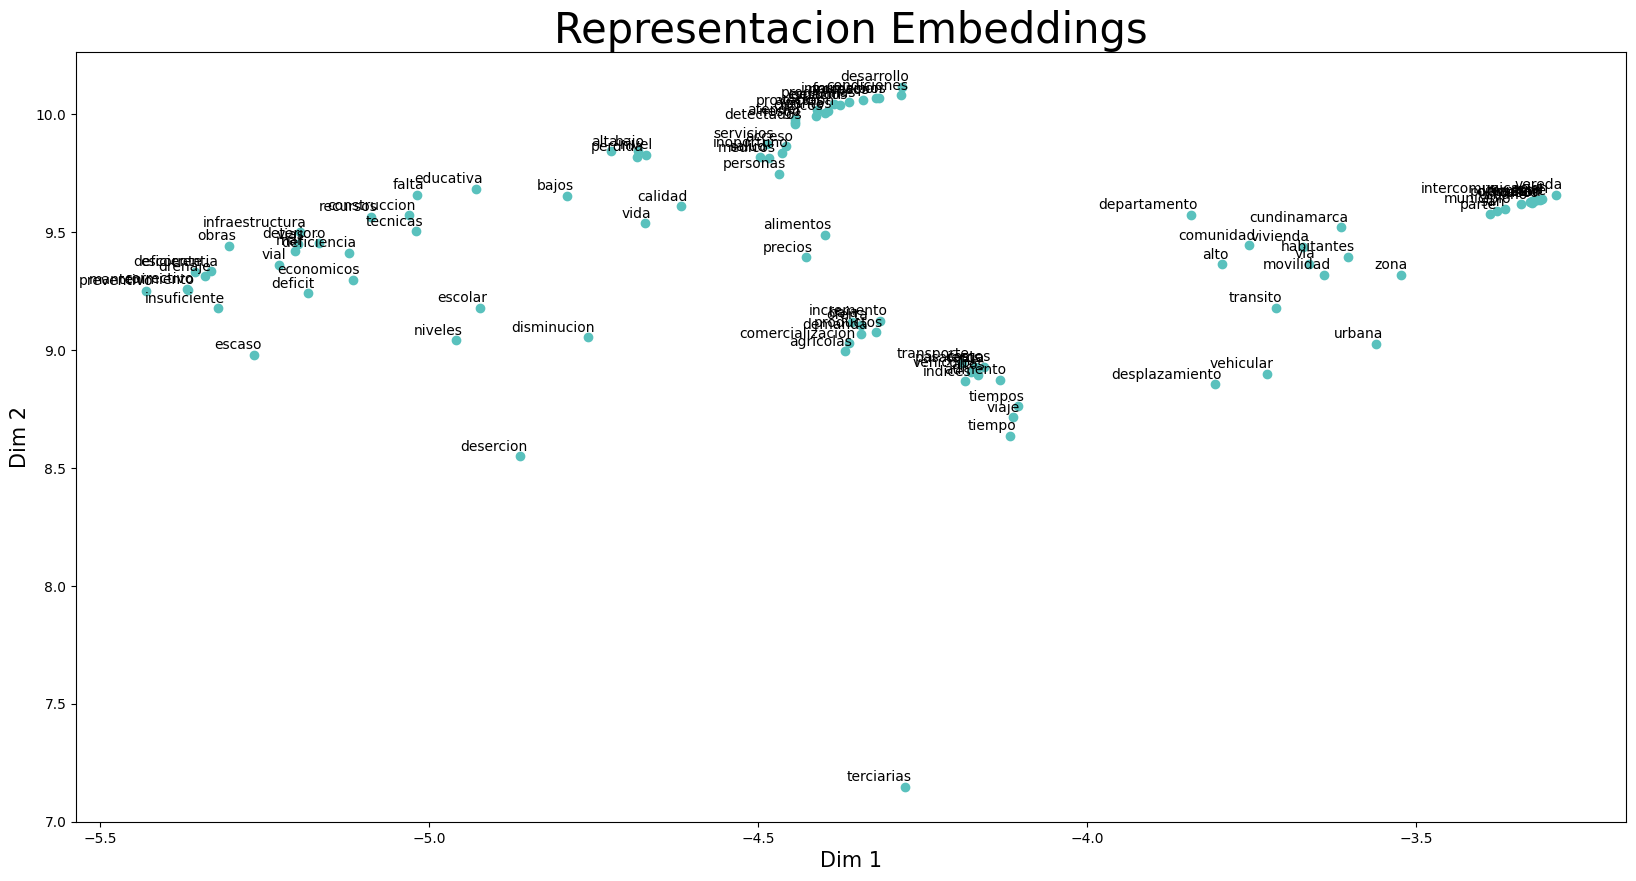

In [187]:
from gensim.models import Word2Vec

sentences = [word for word in data["text_tokenized"]]
embedding_word2vec = Word2Vec(sentences=sentences, min_count=1,vector_size=100)
key_to_vector_embedding = { word: embedding_word2vec.wv[word] for word in vocab_ }
visualize_embedding(key_to_vector_embedding = key_to_vector_embedding, algorithm=UMAP(), word_limit=100)

array([[ 0.16775061,  0.19670737,  0.42450094, ..., -0.46187255,
         0.3119807 ,  0.05747855],
       [-0.8531501 ,  0.47212934, -0.17871816, ..., -0.5693803 ,
         0.12412407, -0.24369837],
       [-0.62470245,  1.0789896 , -0.14383729, ..., -0.3045233 ,
        -0.16090922, -0.35369164],
       ...,
       [-0.00989919,  0.00457684, -0.00995476, ..., -0.01102457,
         0.00931434, -0.01567011],
       [-0.01650898,  0.01139317, -0.00974515, ..., -0.00406873,
         0.01336583,  0.0011954 ],
       [-0.00831008,  0.00201098, -0.00874887, ..., -0.01342508,
        -0.00309808, -0.01144383]], dtype=float32)

In [181]:
reduced_2d_data = TSNE().fit_transform(np.array(vectors))

/home/abdala9512/nlp-evaluacion-problemas-sociales/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/abdala9512/nlp-evaluacion-problemas-sociales/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [182]:
reduced_2d_data

array([[-11.027986, -51.611774],
       [-13.609897, -63.46217 ],
       [-12.123762, -62.197723],
       ...,
       [-15.039552,  19.255571],
       [-20.584095,  18.81924 ],
       [-21.493279,  10.874201]], dtype=float32)

In [134]:
reduced_2d_data = model.fit_transform(vectors)
x, y =  reduced_2d_data[:, 0], reduced_2d_data[:, 1]

Text(0.5, 1.0, 'Representacion Embeddings')

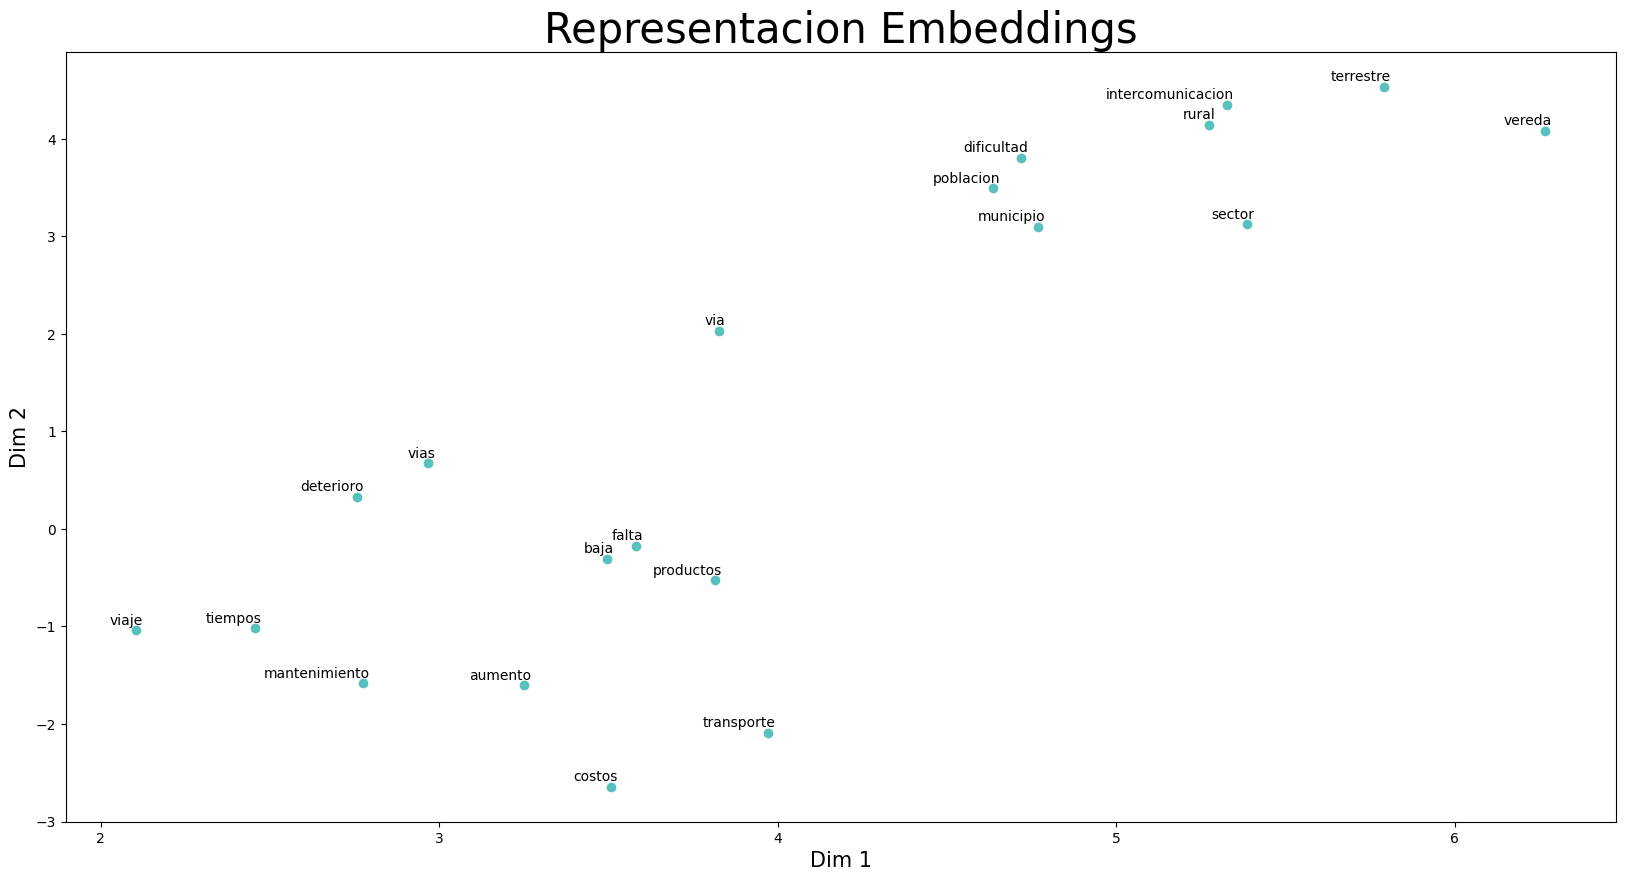

# Modelo

In [174]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict


from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import LSTM, GRU, Dense


In [173]:
max_sequence = max([len(list_) for list_ in sentences])
sentences_padded = pad_sequences(sentences, maxlen=max_sequence, padding='post', truncating='post')

ValueError: invalid literal for int() with base 10: 'deficiencia'

In [168]:
model = Sequential()

In [ ]:
def build_dataset(words):
    count = collections.Counter(words).most_common()
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return dictionary, reverse_dictionary